In [6]:
!pip install rasterio geopandas shapely

     |████████████████████████████████| 19.1 MB 13.5 MB/s eta 0:00:01
     |████████████████████████████████| 994 kB 70.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 69.2 MB/s eta 0:00:01
     |████████████████████████████████| 6.5 MB 52.6 MB/s eta 0:00:01     |██▊                             | 552 kB 52.6 MB/s eta 0:00:01
     |████████████████████████████████| 15.3 MB 71.9 MB/s eta 0:00:01


In [17]:
import os
import rasterio as rio
import numpy as np
from rasterio.windows import Window
from glob import glob
from shapely.geometry import Polygon
from shapely.geometry import box
import geopandas as gpd
from rasterio.windows import get_data_window
import rasterio as rio

# Mount Inference Data

In [26]:
!sudo mount -t nfs4 -o nfsvers=4.1,rsize=1048576,wsize=1048576,hard,timeo=600,retrans=2,noresvport 172.31.91.151:/ ./efs_inference_data

# Windowing

In [27]:
def get_windows(img_dim, patch_size=(240, 240), stride=(240, 240)):
    patch_size = np.array(patch_size)
    stride = np.array(stride)
    img_dim = np.array(img_dim)
    # to take into account edges, add additional blocks around right side edge and bottom edge of raster
    new_img_dim = [img_dim[0] + stride[0],img_dim[1] + stride[0]]
    
    max_dim = (new_img_dim//patch_size)*patch_size - patch_size

    ys = np.arange(0, img_dim[0], stride[0])
    xs = np.arange(0, img_dim[1], stride[1])

    tlc = np.array(np.meshgrid(ys, xs)).T.reshape(-1, 2)
    tlc = tlc[tlc[:, 0] <= max_dim[0]]
    tlc = tlc[tlc[:, 1] <= max_dim[1]]
    
    windows = []
    for y,x in tlc.astype(int):
        windows.append(Window(x, y, patch_size[1], patch_size[0]))

    return windows

In [28]:
def add_ndvi(data, dtype_1=rio.float32):
    
    nir = data[7].astype(dtype_1)
    red = data[3].astype(dtype_1)

    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Calculate NDVI
    ndvi = np.zeros(nir.shape, dtype=dtype_1)
    ndvi = ((nir - red) / (nir + red)).astype(dtype_1)

    # Rescaling for use in 16bit output

    ndvi = (ndvi + 1) * (2**15 - 1)

    # Add NDVI band to end of array    
    rast = np.concatenate((data,[ndvi]),axis=0)
    
    rast = rast.astype(rio.uint16)
    
    return rast


In [29]:
# def save_to_s3():
    
    

In [62]:
def output_windows(granule_dir,out_path,patch_size=100,
                   stride=100,SAVE=False,SAVE_INDIVIDUAL=False,
                   bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]):
    
    granule_list = glob(f'{granule_dir}/*.tif')
    
    granule_id_list = []
    
    window_id_list = []
    
    window_geom_list = []
    
    data_list = []
    
    for granule_path in granule_list[0:1]:
        
        granule_id = granule_path.split("/")[-1].split("_")[0]
        
#         print(granule_id)

#         raster = rio.open(granule_path)
    
        with rio.open(granule_path) as src:
            
#             no_data_window = get_data_window(src.read(bands, masked=True))
#             
#             return no_data_window

    #         affine = raster.transform

    #         print(affine)

            windows = get_windows(src.shape, (patch_size, patch_size), (stride, stride))

            for i, window in enumerate(windows):

                granule_id_list.append(granule_id)

                window_id_list.append(i+1)

                #need to understand impact of "masked" argument for inference

                data = src.read(bands,window=window, masked=True)

                data = add_ndvi(data)
        
                shape = data.shape
            
                new_shape = (data.shape[0],patch_size,patch_size)
            
                if shape != new_shape:

                    filled_array = np.full(new_shape, None)
                    filled_array[:shape[0],:shape[1],:shape[2]] = data
                    data = filled_array
                    window = Window(window.col_off,window.row_off,shape[2],shape[1])
                    

            #     if np.any(data.mask):
                    # THE PATCH CONTAINS NODATA PIXELS, HANDLE AS NEEDED

            #     data = DO_PREPROCESSING(data.data)
            #     result = DO_INFERENCE(data)
            

                
                window_bounds = rio.windows.bounds(window, src.transform, height=patch_size, width=patch_size)
                geom = box(*window_bounds)
                window_geom_list.append(geom)



            gdf = gpd.GeoDataFrame({"granule_id":granule_id_list,"window_id":window_id_list,"geometry":window_geom_list,"labels":None})

            return gdf


    #             if SAVE:

    #                 if SAVE_INDIVIDUAL:
    #                     meta = raster.meta.copy()
    #                     # Get the window specific transform - IF we want to save windows independantly
    #             #         trans = raster.window_transform(window)
    #                     meta.update({
    #             #                 'transform': trans,
    #                             'dtype': src.dtype
    #                         })

    #                     with rasterio.open(f"{out_path}/some_chip_{j}.tif", 'w', **meta) as dest:
    #                         dest.write(data)
    #                 else:
    #                     meta = raster.meta.copy()

    #                     with rasterio.open(f"{out_path}/some_chip_{j}.tif", 'w+', **meta) as dest:
    #                         dest.write(data, window=window)

In [63]:
granule_dir = "./efs_inference_data/"
out_path = "./windows/"

gdf = output_windows(granule_dir,out_path)

<AxesSubplot:>

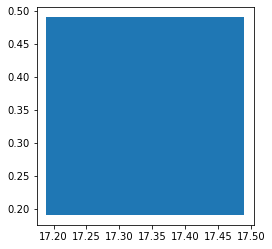

In [64]:
gdf.plot()

In [65]:
gdf.to_file("./inference_output/test.geojson", driver='GeoJSON')

# ML Code